# Cox-PH and DeepSurv

In this notebook we will train the [Cox-PH method](http://jmlr.org/papers/volume20/18-424/18-424.pdf), also known as [DeepSurv](https://bmcmedresmethodol.biomedcentral.com/articles/10.1186/s12874-018-0482-1).
We will use the METABRIC data sets as an example

A more detailed introduction to the `pycox` package can be found in [this notebook](https://nbviewer.jupyter.org/github/havakv/pycox/blob/master/examples/01_introduction.ipynb) about the `LogisticHazard` method.

The main benefit Cox-CC (and the other Cox methods) has over Logistic-Hazard is that it is a continuous-time method, meaning we do not need to discretize the time scale.

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

import torch
import torchtuples as tt

from pycox.datasets import metabric
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv

In [52]:
## Uncomment to install `sklearn-pandas`
# ! pip install sklearn-pandas

In [53]:
np.random.seed(1234)
_ = torch.manual_seed(123)

## Dataset

We load the METABRIC data set and split in train, test and validation.

In [54]:
import pandas as pd

df_train = pd.read_csv('data/Recurrence free survival in breast cancer patients.csv')
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

In [55]:
df_train.head()

,id,treat,age,men,size,grade,nodes,prog,oest,time,status
0,1,0,70,2,21,2,3,48,66,1814,1
1,2,1,56,2,12,2,7,61,77,2018,1
2,3,1,58,2,35,2,9,52,271,712,1
3,4,1,59,2,17,2,4,60,29,1807,1
4,5,0,73,2,35,2,1,26,65,772,1


## Feature transforms
We have 9 covariates, in addition to the durations and event indicators.

We will standardize the 5 numerical covariates, and leave the binary variables as is. As variables needs to be of type `'float32'`, as this is required by pytorch.

In [56]:
cols_standardize = ['treat', 'age', 'men', 'size', 'grade', 'nodes', 'prog', 'oest']
cols_leave = []

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [57]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

We need no label transforms

In [58]:
get_target = lambda df: (df['time'].values, df['status'].values)
y_train = get_target(df_train)
y_val = get_target(df_val)
durations_test, events_test = get_target(df_test)
val = x_val, y_val

## Neural net

We create a simple MLP with two hidden layers, ReLU activations, batch norm and dropout. 
Here, we just use the `torchtuples.practical.MLPVanilla` net to do this.

Note that we set `out_features` to 1, and that we have not `output_bias`.

In [59]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = 1
batch_norm = True
dropout = 0.1
output_bias = False

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias=output_bias)

## Training the model

To train the model we need to define an optimizer. You can choose any `torch.optim` optimizer, but here we instead use one from `tt.optim` as it has some added functionality.
We use the `Adam` optimizer, but instead of choosing a learning rate, we will use the scheme proposed by [Smith 2017](https://arxiv.org/pdf/1506.01186.pdf) to find a suitable learning rate with `model.lr_finder`. See [this post](https://towardsdatascience.com/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6) for an explanation.

In [60]:
model = CoxPH(net, tt.optim.Adam)

/opt/miniconda3/lib/python3.9/site-packages/torchtuples/base.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch.load(path, **kwargs))


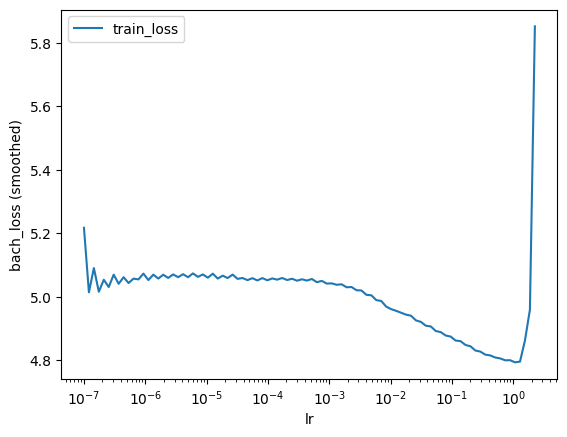

In [61]:
batch_size = 256
lrfinder = model.lr_finder(x_train, y_train, batch_size, tolerance=10)
_ = lrfinder.plot()

In [62]:
lrfinder.get_best_lr()

0.10722672220103299

Often, this learning rate is a little high, so we instead set it manually to 0.01

In [63]:
model.optimizer.set_lr(0.01)

We include the `EarlyStopping` callback to stop training when the validation loss stops improving. After training, this callback will also load the best performing model in terms of validation loss.

In [64]:
epochs = 512
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

In [65]:
%%time
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val, val_batch_size=batch_size)

0:	[0s / 0s],		train_loss: 4.9743,	val_loss: 4.0812
1:	[0s / 0s],		train_loss: 4.7142,	val_loss: 4.1304
2:	[0s / 0s],		train_loss: 4.6932,	val_loss: 4.3106
3:	[0s / 0s],		train_loss: 4.5862,	val_loss: 4.2956
4:	[0s / 0s],		train_loss: 4.5798,	val_loss: 4.1568
5:	[0s / 0s],		train_loss: 4.5724,	val_loss: 4.0894
6:	[0s / 0s],		train_loss: 4.5673,	val_loss: 4.0623
7:	[0s / 0s],		train_loss: 4.6071,	val_loss: 4.0591
8:	[0s / 0s],		train_loss: 4.5400,	val_loss: 4.0673
9:	[0s / 0s],		train_loss: 4.5186,	val_loss: 4.0879
10:	[0s / 0s],		train_loss: 4.5443,	val_loss: 4.1125
11:	[0s / 0s],		train_loss: 4.5038,	val_loss: 4.1292
12:	[0s / 0s],		train_loss: 4.4675,	val_loss: 4.1439
13:	[0s / 0s],		train_loss: 4.4852,	val_loss: 4.1370
14:	[0s / 0s],		train_loss: 4.4843,	val_loss: 4.1018
15:	[0s / 0s],		train_loss: 4.4480,	val_loss: 4.0802
16:	[0s / 0s],		train_loss: 4.4897,	val_loss: 4.0754
17:	[0s / 0s],		train_loss: 4.4875,	val_loss: 4.0738
CPU times: user 71.2 ms, sys: 46 ms, total: 117 ms
Wall 

/opt/miniconda3/lib/python3.9/site-packages/torchtuples/base.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch.load(path, **kwargs))


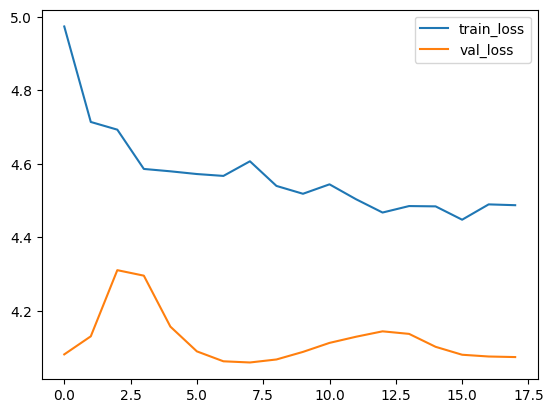

In [66]:
_ = log.plot()

We can get the partial log-likelihood

In [67]:
model.partial_log_likelihood(*val).mean()

-4.0591197

## Prediction

For evaluation we first need to obtain survival estimates for the test set.
This can be done with `model.predict_surv` which returns an array of survival estimates, or with `model.predict_surv_df` which returns the survival estimates as a dataframe.

However, as `CoxPH` is semi-parametric, we first need to get the non-parametric baseline hazard estimates with `compute_baseline_hazards`. 

Note that for large datasets the `sample` argument can be used to estimate the baseline hazard on a subset.

In [68]:
_ = model.compute_baseline_hazards()

In [69]:
surv = model.predict_surv_df(x_test)

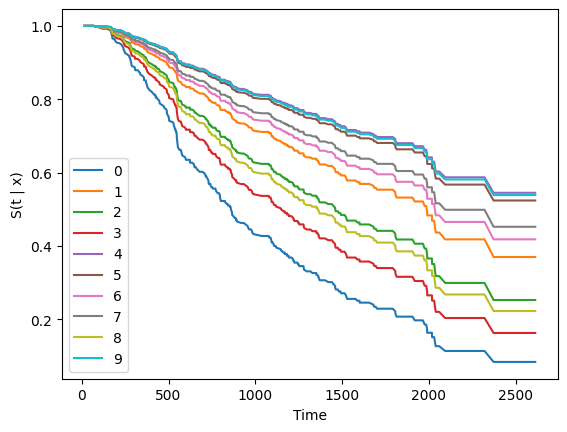

In [70]:
surv.iloc[:, :10].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

## Evaluation

We can use the `EvalSurv` class for evaluation the concordance, brier score and binomial log-likelihood. Setting `censor_surv='km'` means that we estimate the censoring distribution by Kaplan-Meier on the test set.

In [71]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [72]:
print(f"Concordance: {ev.concordance_td():.3f}")

Concordance: 0.649


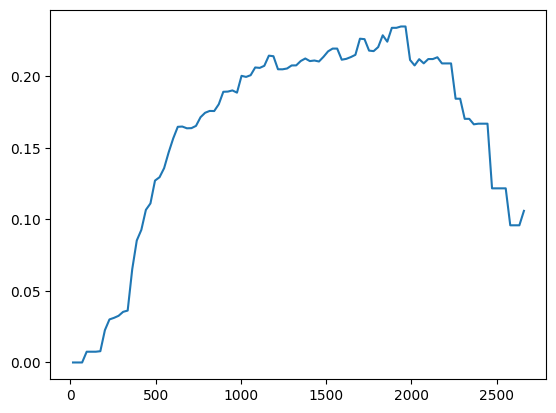

In [73]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
_ = ev.brier_score(time_grid).plot()

In [74]:
ev.integrated_brier_score(time_grid)

0.1626647182583523

In [75]:
ev.integrated_nbll(time_grid)

0.4855507242505739